In [22]:
import os
import re
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

# Catawba [05/22]


In [23]:
# Load catawba manual data
mandf0 = pd.read_excel("../data/manual/05_2022/validation_man.xlsx")

# Assume flat ground 
# Use the angle(θ) and distance from the base of the tree (d) to calculate tree height (h)

# Convert slope (%) to radians
mandf0['angle_rad'] = np.arctan(mandf0['angle']*0.01)

# angle in degrees
mandf0['angle_deg'] = np.rad2deg(mandf0['angle_rad'])

# compute tree height = tan(θ) * distance (d) + viewer height 
mandf0['height_ft'] = np.tan(mandf0['angle_rad']) * mandf0['distance'] + 5.375 # John height = 64.5 in == 5.375 ft

# Convert ft --> in 
mandf0['height'] = mandf0['height_ft'] * 12.

# Fill in the tree heights that were measured without clinometer (shorties)
mandf0['height'][np.isnan(mandf0['height_ft'])] = mandf0['height_in']

# inches to cm
mandf0['diam'] = mandf0['diam']*2.54
mandf0['height'] = mandf0['height']*2.54

# add col with measurement approaches 
mandf0['method'] = 'manual_0'

# add col with site 
mandf0['site'] = 'catawba'


<ipython-input-23-6911e18ec360>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mandf0['height'][np.isnan(mandf0['height_ft'])] = mandf0['height_in']


In [24]:
# Read db dump
measurements = []
for line in open('../data/app/05_2022/bquxjob_4eb29efb_180f7d82eb2.json', 'r'):
    measurements.append(json.loads(line))

In [25]:
# extract the relevant info 
outrows = []
for idx,tree in enumerate(measurements):
    diam = float(measurements[idx]['diameter']['value']) * 2.54 # in to cm
    height = float(measurements[idx]['height']['value']) * 2.54 # in to cm
    unit = measurements[idx]['height']['unit']
    species = measurements[idx]['speciesName']
    date = measurements[idx]['captureDate']
    parcel = measurements[idx]['parcelId']
    lat = measurements[idx]['lat']
    lon = measurements[idx]['long']
    tree_id = measurements[idx]['id']
    diam_url = measurements[idx]['photos'][0]['url']
    height_url = measurements[idx]['photos'][1]['url']

    treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel]).T
    treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id']
    outrows.append(treedf)
    
# concat 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)

# Isolate field campaign dates
mask = (valdf['date'] >= "2022-05-12") & (valdf['date'] <= '2022-05-14')
appdf = valdf[mask]
appdf = appdf.sort_values(by='date', ascending = True)[1:]
pid = list(appdf['parcel_id'])[0]
appdf['parcel_id'] = pid

In [26]:
mask = (valdf['date'] >= "2022-05-12") & (valdf['date'] <= '2022-05-14')
appdf = valdf[mask]
appdf = appdf.sort_values(by='date', ascending = True)[1:]
pid = list(appdf['parcel_id'])[0]
appdf['parcel_id'] = pid

In [27]:
compdf = pd.merge(appdf, mandf0, on = 'tree_id')
compdf.rename(columns = {'diam_x':'diam_app', 'diam_y':'diam', 'height_x':'height_app', 'height_y':'height'}, inplace = True)

In [28]:
compdf.to_csv("../data/catawba_05_22.csv")

# Kentland [10/22]


In [29]:
# Load the manual dataframes
mandf1 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 1")
mandf2 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 2")

# ft --> inches 
mandf1['height_1'] = mandf1['Height (ft)'] * 12
mandf2['height_2'] = mandf2['Height (ft)'] * 12
mandf1['diam_1'] = mandf1["DBH (In)"] * 2.54 # in to cm
mandf2['diam_2'] = mandf2["DBH (In)"] * 2.54 # in to cm

# add col with measurement approaches 
mandf1['method'] = 'manual 1'
mandf2['method'] = 'manual 2'

# add col with site 
mandf2['site'] = 'kentland'
mandf1['site'] = 'kentland'

mandf1_clean = mandf1.drop(["Height (ft)", "DBH (In)"], axis = 1)
mandf2_clean = mandf2.drop(["Height (ft)", "DBH (In)"], axis = 1)

# Merge back
manual_10_22= pd.merge(mandf1_clean, mandf2_clean, right_on=['Row#','Tree#'], left_on = ['Row#','Tree#'], how='outer')
manual_10_22['height_mean'] = manual_10_22[['height_1','height_2']].mean(axis = 1)
manual_10_22['diam_mean'] = manual_10_22[['diam_1','diam_2']].mean(axis = 1)


In [30]:
# Load app sampling datasets and do lots of formatting
# Read db dump
measurements = []
for line in open('../data/app/10_2022/validation_10_2022.json', 'r'):
    measurements.append(json.loads(line))

# Extract trees line by line

outrows = []

for idx,tree in enumerate(measurements):
    try:
        diam = measurements[idx]['diameter']['value']
        height = measurements[idx]['height']['value']
        unit = measurements[idx]['height']['unit']
        species = measurements[idx]['speciesName']
        date = measurements[idx]['captureDate']
        parcel = measurements[idx]['parcelId']
        lat = measurements[idx]['lat']
        lon = measurements[idx]['long']
        tree_id = measurements[idx]['id']
        diam_url = measurements[idx]['photos'][0]['url']
        height_url = measurements[idx]['photos'][1]['url']
        notes = measurements[idx]['notes']

        treedf = pd.DataFrame([date,lat,lon,tree_id,diam,height,species,height_url, diam_url,parcel, notes]).T
        treedf.columns = ['date','lat','lon','tree_id','diam','height','species','height_url', 'diam_url','parcel_id','notes']
        outrows.append(treedf)
        
    except:
        continue
    
    
# concat 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)

# Filter out parcels with a single measurement - this leaves just Sanjok x2 and Brenda 
valdf = pd.concat(outrows, axis = 0)
valdf['date'] = pd.to_datetime(valdf['date'])
valdf = valdf.sort_values(by='date', ascending = True)
# Count n rows in each parcel 
valdf['parcel_id'].value_counts()
# record 
counts = valdf['parcel_id'].value_counts(dropna=False) 
valids = counts[counts>1].index
# filter 
appdf = valdf[valdf['parcel_id'].isin(valids)]
# Extract the indices for each tree

notescol = list(appdf['notes'])

rows = []
cols = []

for x in notescol:
    xstr = x.lower()
    rows.append(re.sub('[^0-9]','', xstr.split("p")[0]))
    cols.append(re.sub('[^0-9]','', xstr.split("p")[1]))

# Apply indices  
appdf['row'] = rows
appdf['tree_idx'] = cols

appdf['row'] = appdf['row'].astype(float)
appdf['tree_idx'] = appdf['tree_idx'].astype(float)
appdf['diam'] = appdf['diam'].astype(float) * 2.54 # in to cm
appdf['height'] = appdf['height'].astype(float) * 2.54 # in to cm 
appdf['lat'] = appdf['lat'].astype(float)
appdf['lon'] = appdf['lon'].astype(float)

appdf.replace({'parcel_id':{'5F2EA33C-65AD-4826-BF5C-D585E410C877':'User 1',
                           'A57E7C65-8B5C-43B2-9110-5A6A4ECFBC35':'User 2',
                           '48A3274A-5E61-4644-8C5E-0E856E87AF4F':'User 3'}}, inplace = True)
    


<ipython-input-30-33ef9a42aab1>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdf['row'] = rows
<ipython-input-30-33ef9a42aab1>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appdf['tree_idx'] = cols
<ipython-input-30-33ef9a42aab1>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [31]:
tdfs = []

# For each tree (unique row / col combo index), calculate mean and variance for errorbar plots 
for ridx in appdf['row'].unique():
    ardf = appdf[appdf['row']==ridx]
    mrdf = manual_10_22[manual_10_22['Row#'] == ridx]
    for tidx in appdf['tree_idx'].unique():
        atdf = ardf[ardf['tree_idx'] == tidx]
        mtdf = mrdf[mrdf['Tree#'] == tidx]
        if len(atdf) > 0 and len(mtdf) > 0:
            app_tree_df = pd.DataFrame([atdf['diam'].mean(),atdf['diam'].std(), len(atdf['diam'])]).T
            man_tree_df = pd.DataFrame([mtdf[['diam_1','diam_2']].values.mean(),mtdf[['diam_1','diam_2']].values.std(), len(mtdf[['diam_1','diam_2']].values), mtdf['SN_x'].iloc[0],mtdf['Species_x'].iloc[0]]).T
            app_tree_df.columns = ['app mean','app var','app n']
            man_tree_df.columns = ['man mean','man var','man n', 'tree idx', 'species']
            
            odf = pd.concat([app_tree_df,man_tree_df], axis = 1)
            
            tdfs.append(odf)

In [32]:
appdf_mean = pd.concat(tdfs).reset_index().drop("index", axis = 1).dropna()


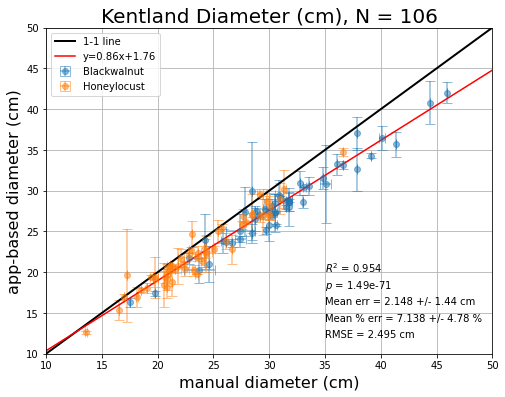

In [33]:

groups = appdf_mean.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.errorbar(group['man mean'],
             group['app mean'],
             yerr=group['app var'], 
             xerr = group['man var'], 
             linestyle="None", marker='o',capsize=5, label=name, markersize = 6, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(appdf_mean['man mean'].astype(float), appdf_mean['app mean'])

# Mean absolute error
mae = np.nanmean(abs(appdf_mean['man mean'] - appdf_mean['app mean']))
mae_std = np.nanstd((appdf_mean['man mean'] - appdf_mean['app mean']))
mape = np.nanmean(((appdf_mean['man mean'] - appdf_mean['app mean']) / appdf_mean['man mean'])) * 100
mape_std = np.nanstd(((appdf_mean['man mean'] - appdf_mean['app mean']) / appdf_mean['man mean'])) * 100
rmse = ((appdf_mean['man mean'] - appdf_mean['app mean']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [35,20])
plt.annotate("$p$ = {:.2e}".format(p_value), [35,18])
plt.annotate("Mean err = {} +/- {} cm".format(str(round(mae,5))[:5],str(round(mae_std,2))), [35,16])
plt.annotate("Mean % err = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [35,14])
plt.annotate("RMSE = {} cm".format(str(round(rmse,5))[:5],), [35,12])

ax.legend()
ax.set_xlim(10,50)
ax.set_ylim(10,50)
    
plt.xlabel("manual diameter (cm)", size = 16)
plt.ylabel("app-based diameter (cm)", size = 16)


titlestr = "Kentland Diameter (cm), N = {}".format(str(len(appdf_mean)))
plt.title(titlestr, size = 20)
plt.grid()
plt.show()

In [34]:
# Load the manual dataframes
mandf1 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 1")
mandf2 = pd.read_excel("../data/manual/10_2022/Working Tree Kentland 2022_SP.xlsx", sheet_name = "Kentland 2")

# ft --> inches 
mandf1['height_1'] = mandf1['Height (ft)'] * 12
mandf2['height_2'] = mandf2['Height (ft)'] * 12
mandf1['diam_1'] = mandf1["DBH (In)"] * 2.54 # in to cm
mandf2['diam_2'] = mandf2["DBH (In)"] * 2.54 # in to cm

# add col with measurement approaches 
mandf2['method'] = 'manual 2'
mandf1['method'] = 'manual 1'

# add col with site 
mandf2['site'] = 'kentland'
mandf1['site'] = 'kentland'

mandf1_clean = mandf1.drop(["Height (ft)", "DBH (In)"], axis = 1)
mandf2_clean = mandf2.drop(["Height (ft)", "DBH (In)"], axis = 1)

# Merge back
manual_10_22= pd.merge(mandf1_clean, mandf2_clean, right_on=['Row#','Tree#'], left_on = ['Row#','Tree#'], how='outer')
manual_10_22['height_mean'] = manual_10_22[['height_1','height_2']].mean(axis = 1)
manual_10_22['diam_mean'] = manual_10_22[['diam_1','diam_2']].mean(axis = 1)

# Filtering of app data 
appdf.loc[appdf["species"] == 'Black Locust', 'species'] = "Black Walnut"
appdf.loc[appdf["species"] == 'Honey locust', 'species'] = "Honey Locust"
appdf.rename(columns = {"parcel_id":"user"}, inplace = True)

data1 = pd.DataFrame(appdf[appdf['user']=='User 1'][['diam','user','species']])
data2 = pd.DataFrame(appdf[appdf['user']=='User 2'][['diam','user','species']])
data3 = pd.DataFrame(appdf[appdf['user']=='User 3'][['diam','user','species']])

# Filtering of manual data 
manual_10_22.loc[manual_10_22["Species_x"] == 'Honeylocust', 'species'] = "Honey Locust"
manual_10_22.loc[manual_10_22["Species_x"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["Species_y"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["Species_y"] == 'Blackwalnut', 'species'] = "Black Walnut"
manual_10_22.loc[manual_10_22["method_x"] == 'manual 1', 'method'] = "manual 1"
manual_10_22.loc[manual_10_22["method_y"] == 'manual 2', 'method'] = "manual 2"
# manual_10_22.rename(columns = {'method_x':'user', 'method_y':'user'}, inplace = True)

m1 = manual_10_22[['diam_1','method_x','species']].rename(columns = {'diam_1':'diam','method_x':'user'})
m2 = manual_10_22[['diam_2','method_y','species']].rename(columns = {'diam_2':'diam','method_y':'user'})
# m2['user'] = 'manual 2'

cdf = pd.concat([data1, data2, data3,m1,m2])    
# mdf = pd.melt(cdf, id_vars=['species'], var_name=['user'])


/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/aakashahamed/anaconda3/envs/rsenv/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


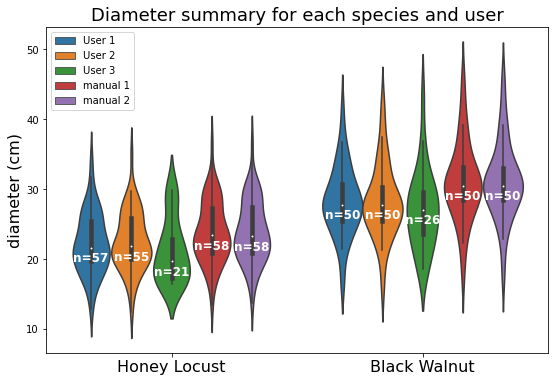

In [43]:
fig, ax = plt.subplots(figsize = (9,6))
ax = sns.violinplot(x="species", y="diam", hue="user", data=cdf)

medians = cdf.groupby(['user','species'])['diam'].median()
nobs =  cdf.groupby(['user','species']).apply(lambda x: 'n={}'.format(len(x)))

for ax in plt.gcf().axes:

    for tick, label in enumerate(ax.get_xticklabels()):
        ax_species = label.get_text()

        for j, ax_user in enumerate(ax.get_legend_handles_labels()[1]):
            x_offset = (j - (5-1)/2) * (5/((5*1)+1-1)) * 0.16
            med_val = medians[ax_user, ax_species] - 2.
            num = nobs[ax_user, ax_species]

            ax.text(tick + x_offset, med_val, num,
                    horizontalalignment='center', size='large', color='w', weight='semibold')

ax.tick_params(axis='x', labelsize=16)
plt.legend(title = None, loc = 'upper left')
plt.ylabel("diameter (cm)", size = 16)
plt.xlabel("")
plt.title("Diameter summary for each species and user", size = 18)
plt.show()

In [15]:
# Merge app + manual 
kentland_df = pd.merge(appdf, manual_10_22,  how='left', right_on=['Row#','Tree#'], left_on = ['row','tree_idx']).dropna()
# kentland_df.rename(columns = {'diam_x':'diam_app', 'diam_y':'diam', 'height_x':'height_app', 'height_y':'height', 'Species':'species'}, inplace = True)

In [16]:
# Set col names 
kentland_df['species'] = kentland_df['species_x'].replace("Honeylocust", "Honey Locust")
kentland_df['species'] = kentland_df['species_x'].replace("Blacklocust", "Black Locust")
kentland_df['species'] = kentland_df['species_x'].replace("Blackwalnut", "Black Walnut")

In [17]:
# Write
kentland_df.to_csv("../data/kentland_10_22.csv")

In [18]:
udfs = []

for u in cdf.user.unique():
    udf = cdf[cdf['user'] == u].drop(["user",'species'],axis = 1)
    udft = udf.reset_index().drop(['index'], axis = 1)
    udft.columns = [u]
    udfs.append(udft)

In [19]:
anovadf = pd.concat(udfs, axis = 1)

In [20]:
# 1/1
print("U1 M1")
print(stats.f_oneway(anovadf['User 1'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 1'].dropna(), anovadf['manual 1'].dropna()))

# 2/1
print("U2 M1")
print(stats.f_oneway(anovadf['User 2'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 2'].dropna(), anovadf['manual 1'].dropna()))

# 3/1
print("U3 M1")
print(stats.f_oneway(anovadf['User 3'].dropna(), anovadf['manual 1'].dropna()))
print(stats.levene(anovadf['User 3'].dropna(), anovadf['manual 1'].dropna()))

U1 M1
F_onewayResult(statistic=6.806690974605055, pvalue=0.009725331971270647)
LeveneResult(statistic=1.205428482958001, pvalue=0.27347896243813963)
U2 M1
F_onewayResult(statistic=5.700558450996921, pvalue=0.017841673651445355)
LeveneResult(statistic=1.5965217106214846, pvalue=0.20779110333586848)
U3 M1
F_onewayResult(statistic=6.307090157083922, pvalue=0.013063715561018784)
LeveneResult(statistic=0.06926459650062285, pvalue=0.7927646395497254)


In [21]:
# 1/2
print("U1 M2")
print(stats.f_oneway(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 1'].dropna(), anovadf['manual 2'].dropna()))

# 2/2
print("U2 M2")
print(stats.f_oneway(anovadf['User 2'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 2'].dropna(), anovadf['manual 2'].dropna()))

# 3/2
print("U3 M2")
print(stats.f_oneway(anovadf['User 3'].dropna(), anovadf['manual 2'].dropna()))
print(stats.levene(anovadf['User 3'].dropna(), anovadf['manual 2'].dropna()))

U1 M2
F_onewayResult(statistic=7.4568982247990085, pvalue=0.006848793380008096)
LeveneResult(statistic=1.0268545631203914, pvalue=0.31204828564623477)
U2 M2
F_onewayResult(statistic=6.288914647619892, pvalue=0.012902836549748031)
LeveneResult(statistic=1.393843874939692, pvalue=0.2390861921690272)
U3 M2
F_onewayResult(statistic=6.796845389912822, pvalue=0.01003550450429822)
LeveneResult(statistic=0.04100289069986926, pvalue=0.839801356880223)


In [ ]:
for sp in kentland_df['species'].unique():
    print(sp)
    spdf = kentland_df[kentland_df['species'] == sp]
    print("MANUAL")
    print(np.nanmean(spdf['diam'].values))
    print(np.nanvar(spdf['diam'].values))
    print("APP")
    print(np.nanmean(spdf['diam_app'].values))
    print(np.nanvar(spdf['diam_app'].values))

In [ ]:
tdfs = []

# For each tree (unique row / col combo index), calculate: 1. mean lat/lon, 2. mean height, 3. mean diam 
for ridx in appdf['row'].unique():
    ardf = appdf[appdf['row']==ridx]
    for tidx in appdf['tree_idx'].unique():
        rtdf = ardf[ardf['tree_idx'] == tidx]
        if len(rtdf) > 0:
            tree_df = pd.DataFrame(rtdf[['diam','height','lat','lon']].mean()).T
            tree_df['row'] = ridx
            tree_df['tree_idx'] = tidx
            tdfs.append(tree_df)

In [ ]:
# Read datasets from the validations 

val1 = pd.read_csv("../results/catawba_05_22/results.csv")
val2 = pd.read_csv("../results/kentland_10_22/results.csv")

val2.rename({"species_app":"species"}, inplace = True)
val2.rename({"Species":"species_app"}, inplace = True)

In [ ]:
val2.columns

In [ ]:
# Combine the app data

diam_app_all = pd.concat([val1[['diam_app','species']],val2[['diam_app','species']]])
height_app_all = pd.concat([val1[['height_app','species']],val2[['height_app','species']]])

# Combine the manual data 

diam_man_all = pd.concat([val1[['diam','species']],val2[['diam','species']]])
height_man_all = pd.concat([val1[['height_in','species']],val2[['height_in','species']]])

In [ ]:
# Combine manual + app for diameter + height 

diam_all = pd.concat([diam_app_all,diam_man_all], axis = 1).iloc[:, :-1]
height_all = pd.concat([height_app_all,height_man_all], axis = 1).iloc[:, :-1]

In [ ]:
# Diam linear regression grouped by species 

groups = diam_all.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.plot(group['diam'], group['diam_app'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(diam_all['diam'], diam_all['diam_app'])

# Mean absolute error
mae = np.nanmean(abs(diam_all['diam'] - diam_all['diam_app']))
mae_std = np.nanstd(abs(diam_all['diam'] - diam_all['diam_app']))
mape = np.nanmean(np.abs((diam_all['diam'] - diam_all['diam_app']) / diam_all['diam'])) * 100
mape_std = np.nanstd(np.abs((diam_all['diam'] - diam_all['diam_app']) / diam_all['diam'])) * 100
rmse = ((diam_all['diam'] - diam_all['diam_app']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [14,3.5])
plt.annotate("$p$ = {:.2e}".format(p_value), [14,2.75])
plt.annotate("MAE = {} +/- {} in".format(str(round(mae,5))[:5],str(round(mae_std,2))), [14,2])
plt.annotate("MAPE = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [14,1.25])
plt.annotate("RMSE = {} in".format(str(round(rmse,5))[:5],), [14,0.5])

ax.legend()
ax.set_xlim(0,20)
ax.set_ylim(0,20)
    
plt.xlabel("manual diameter (in)", size = 16)
plt.ylabel("app-based diameter (in)", size = 16)


titlestr = "Diameter (in), N = {}".format(str(len(diam_all)))
plt.title(titlestr, size = 20)
plt.show()

In [ ]:
# Fit a 3rd order polynomial to the height data instead of the linear regression 

x = height_all['height_in']
y = height_all['height_app']

def func(x, a, b, c):
    return a*x**2+ b*x* + c

# plt.plot(x, y, 'bo', label='Raw Data')

popt, pcov = curve_fit(func, x, y)
a, b, c = popt

In [ ]:
groups = height_all.groupby('species')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.plot(group['height_in'], group['height_app'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,3000],[0,3000],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(height_all['height_in'], height_all['height_app'])

# Mean absolute error
mae = np.nanmean(abs(height_all['height_in'] - height_all['height_app']))
mae_std = np.nanstd(abs(height_all['height_in'] - height_all['height_app']))
mape = np.nanmean(np.abs((height_all['height_in'] - height_all['height_app']) / height_all['height_in'])) * 100
mape_std = np.nanstd(np.abs((height_all['height_in'] - height_all['height_app']) / height_all['height_in'])) * 100
rmse = ((height_all['height_in'] - height_all['height_app']) ** 2).mean() ** .5

# get equation string 
eq_str = "$y = {}x^2 + {}x + {}$".format( *[str(round(x,3)) for x in popt] )

# Linear regression
line = slope*np.linspace(0,900)+ intercept
plt.plot(np.linspace(0,900), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))

# 3rd order polynomial fit 
plt.plot(sorted(x), sorted(func(x, *popt)), color = 'blue', linewidth = 2, label=eq_str)

# annotations 
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [15,500])
plt.annotate("$p$ = {}".format(str(round(p_value,5))[:5]), [15,470])
plt.annotate("MAE = {} +/- {} in".format(str(round(mae,5))[:5],str(round(mae_std,2))), [15,440])
plt.annotate("MAPE = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [15,410])
plt.annotate("RMSE = {} in".format(str(round(rmse,5))[:5],), [15,380])

# plt.annotate(, [400,10], color = 'blue', size = 12)

ax.legend(loc = "upper left")
ax.set_xlim(0,850)
ax.set_ylim(0,850)
    
plt.xlabel("manual height (in)", size = 16)
plt.ylabel("app-based height (in)", size = 16)

titlestr = "Height (in), N = {}".format(str(len(height_all)))
plt.title(titlestr, size = 20)
plt.show()

In [ ]:
# # Group by USER instead of species

# Combine the app data

diam_app_usr = pd.concat([val1[['diam_app','parcel_id']],val2[['diam_app','parcel_id']]])
height_app_usr = pd.concat([val1[['height_app','parcel_id']],val2[['height_app','parcel_id']]])

# Combine the manual data 

diam_man_usr = pd.concat([val1[['diam','parcel_id']],val2[['diam','parcel_id']]])
height_man_usr = pd.concat([val1[['height_in','parcel_id']],val2[['height_in','parcel_id']]])

# Combine manual + app for diameter + height 

diam_usr = pd.concat([diam_app_usr,diam_man_usr], axis = 1).iloc[:, :-1]
height_usr = pd.concat([height_app_usr,height_man_usr], axis = 1).iloc[:, :-1]

diam_usr['parcel_id'].replace({'BDB47999-95D1-4967-BDC4-6A4D43138D5F' : "User1",
       '48A3274A-5E61-4644-8C5E-0E856E87AF4F' : "User2",
       '5F2EA33C-65AD-4826-BF5C-D585E410C877' : "User3",
       'A57E7C65-8B5C-43B2-9110-5A6A4ECFBC35' : "User4"}, inplace = True)

height_usr['parcel_id'].replace({'BDB47999-95D1-4967-BDC4-6A4D43138D5F' : "User1",
       '48A3274A-5E61-4644-8C5E-0E856E87AF4F' : "User2",
       '5F2EA33C-65AD-4826-BF5C-D585E410C877' : "User3",
       'A57E7C65-8B5C-43B2-9110-5A6A4ECFBC35' : "User4"}, inplace = True)

In [ ]:
# Diam linear regression grouped by USER  

groups = diam_usr.groupby('parcel_id')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.plot(group['diam'], group['diam_app'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,300],[0,300],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(diam_usr['diam'], diam_usr['diam_app'])

# Mean absolute error
mae = np.nanmean(abs(diam_usr['diam'] - diam_usr['diam_app']))
mae_std = np.nanstd(abs(diam_usr['diam'] - diam_usr['diam_app']))
mape = np.nanmean(np.abs((diam_usr['diam'] - diam_usr['diam_app']) / diam_usr['diam'])) * 100
mape_std = np.nanstd(np.abs((diam_usr['diam'] - diam_usr['diam_app']) / diam_usr['diam'])) * 100
rmse = ((diam_usr['diam'] - diam_usr['diam_app']) ** 2).mean() ** .5

# regression line 
line = slope*np.linspace(0,300)+ intercept
plt.plot(np.linspace(0,300), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [14,3.5])
plt.annotate("$p$ = {}".format(str(round(p_value,5))[:5]), [14,2.75])
plt.annotate("MAE = {} +/- {} in".format(str(round(mae,5))[:5],str(round(mae_std,2))), [14,2])
plt.annotate("MAPE = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [14,1.25])
plt.annotate("RMSE = {} in".format(str(round(rmse,5))[:5],), [14,0.5])

ax.legend(loc = 'upper left')
ax.set_xlim(0,20)
ax.set_ylim(0,20)
    
plt.xlabel("manual diameter (in)", size = 16)
plt.ylabel("app-based diameter (in)", size = 16)


titlestr = "Diameter (in), N = {}".format(str(len(diam_usr)))
plt.title(titlestr, size = 20)
plt.show()

In [ ]:
groups = height_usr.groupby('parcel_id')

# Plot
fig, ax = plt.subplots(figsize = (8,6))

for name, group in groups:
    ax.plot(group['height_in'], group['height_app'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Plot 1-1 line
ax.plot([0,3000],[0,3000],'k-', lw=2, label = '1-1 line')

# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(height_all['height_in'], height_all['height_app'])

# Mean absolute error
mae = np.nanmean(abs(height_usr['height_in'] - height_usr['height_app']))
mae_std = np.nanstd(abs(height_usr['height_in'] - height_usr['height_app']))
mape = np.nanmean(np.abs((height_usr['height_in'] - height_usr['height_app']) / height_all['height_in'])) * 100
mape_std = np.nanstd(np.abs((height_usr['height_in'] - height_usr['height_app']) / height_all['height_in'])) * 100
rmse = ((height_all['height_in'] - height_all['height_app']) ** 2).mean() ** .5

# get equation string 
eq_str = "$y = {}x^2 + {}x + {}$".format( *[str(round(x,3)) for x in popt] )

# 3rd order polynomial fit 
plt.plot(sorted(x), sorted(func(x, *popt)), color = 'blue', linewidth = 2, label=eq_str)

# annotations 
plt.annotate("$R^2$ = {}".format(str(r_value**2)[:5]), [15,500])
plt.annotate("$p$ = {}".format(str(round(p_value,5))[:5]), [15,470])
plt.annotate("MAE = {} +/- {} in".format(str(round(mae,5))[:5],str(round(mae_std,2))), [14,440])
plt.annotate("MAPE = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [14,410])
plt.annotate("RMSE = {} in".format(str(round(rmse,5))[:5],), [15,380])

ax.legend(loc = "upper left")
ax.set_xlim(0,850)
ax.set_ylim(0,850)
    
plt.xlabel("manual height (in)", size = 16)
plt.ylabel("app-based height (in)", size = 16)

titlestr = "Height (in), N = {}".format(str(len(height_usr)))
plt.title(titlestr, size = 20)
plt.show()

In [ ]:
# min / max scaling for height 

# Standardization
def mean_std(arr):
    return (arr - arr.mean()) / arr.std()

def min_max(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

# Setup vars
height_all['height_in_scaled'] = min_max(height_all['height_in'])
height_all['height_app_scaled'] = min_max(height_all['height_app'])

groups = height_all.groupby('species')
x = height_all['height_in']
y = height_all['height_app']
x_s, y_s = min_max(x), min_max(y)

plt.figure(figsize = (8,6))
for name, group in groups:
    plt.plot(group['height_in_scaled'], group['height_app_scaled'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(x_s, y_s)

# stats
mae = np.nanmean(abs(x_s - y_s))
mae_std = np.nanstd(abs(x_s - y_s))
mape = np.nanmean(abs(x_s - y_s) /y_s) * 100
mape_std = np.nanstd(abs(x_s - y_s) /y_s) * 100
rmse = ((x_s-y_s) ** 2).mean() ** .5

# Linear regression
line = slope*np.linspace(0,900)+ intercept
plt.plot(np.linspace(0,900), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot([-300,300],[-300,300],'k-', lw=2, label = '1-1 line')
plt.xlim([np.nanmin(x_s), np.nanmax(x_s)])
plt.ylim([np.nanmin(y_s), np.nanmax(y_s)])
# plt.scatter(x_s, y_s)
plt.xlabel("min/max scaled manual height", size = 12)
plt.ylabel("min/max scaled app-based height", size = 12)
plt.title("Height (min - max scaling applied)", size = 20)

plt.annotate("MAPE = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [0.5,0.01])
# plt.annotate("RMSE = {} in".format(str(round(rmse,5))[:5]), [0.4,0.15])
plt.annotate("$R^2 = {}$".format(str(round(r_value**2,5))[:5]), [0.5,0.05])

plt.legend()
plt.show()

In [ ]:
# Mean / STD scaling

# Setup vars
height_all['height_in_scaled'] = mean_std(height_all['height_in'])
height_all['height_app_scaled'] = mean_std(height_all['height_app'])

groups = height_all.groupby('species')
x = height_all['height_in']
y = height_all['height_app']
x_s, y_s = mean_std(x), mean_std(y)

plt.figure(figsize = (8,6))
for name, group in groups:
    plt.plot(group['height_in_scaled'], group['height_app_scaled'], marker='o', linestyle='', ms=7, label=name, alpha = 0.5)
    
# Compute regression 
slope, intercept, r_value, p_value, std_err = stats.linregress(x_s, y_s)

# stats
mae = np.nanmean(abs(x_s - y_s))
mae_std = np.nanstd(abs(x_s - y_s))
mape = np.nanmean(abs(x_s - y_s) /y_s) * 100
mape_std = np.nanstd(abs(x_s - y_s) /y_s) * 100
rmse = ((x_s-y_s) ** 2).mean() ** .5

# Linear regression
line = slope*np.linspace(-900,900)+ intercept
plt.plot(np.linspace(-900,900), line, 'r', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot([-300,300],[-300,300],'k-', lw=2, label = '1-1 line')
plt.xlim([np.nanmin(x_s), np.nanmax(x_s)])
plt.ylim([np.nanmin(y_s), np.nanmax(y_s)])
# plt.scatter(x_s, y_s)
plt.xlabel("min/max scaled manual height", size = 12)
plt.ylabel("min/max scaled app-based height", size = 12)
plt.title("Height (mean - std scaling applied)", size = 20)

plt.annotate("MAPE = {} +/- {} %".format(str(round(mape,5))[:5],str(round(mape_std,2))), [0.5,-2])
# plt.annotate("RMSE = {} in".format(str(round(rmse,5))[:5]), [0.4,0.15])
plt.annotate("$R^2 = {}$".format(str(round(r_value**2,5))[:5]), [0.5,-1.75])

plt.legend()
plt.show()

In [ ]:
t_val =  1.96

# Compute upper and lower confidence intervals 
CI_upper = diam_all['diam'].mean() + t_val * diam_all['diam'].std() / np.sqrt(len(diam_all))
CI_lower = diam_all['diam'].mean() - t_val * diam_all['diam'].std() / np.sqrt(len(diam_all))

# Margin of error 
E = (CI_upper - CI_lower) / 2

print(E)

# Bland - Altman Plot

In [ ]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(diam_all['diam_app'], diam_all['diam'],  ax = ax)
plt.title("Bland-Altman Plot for Tree Diameter (in)", size = 25)
plt.show()

# 8
print("{} % of the data falls within 95% Diameter CI".format(str(round((100 - ((8/len(diam_all)) * 100)),3))))

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(height_all['height_app'], height_all['height_in'], ax = ax)
plt.title("Bland-Altman Plot for Tree Height (in)", size = 25)
plt.show()

print("{} % of the data falls within 95% Height CI".format(str(round((100 - ((12/len(height_all)) * 100)),3))))


# Concordance Correlation Coefficient:

# $ \rho_c = \frac{2 \rho \sigma_x \sigma_y}{\sigma_{x}^{2} + \sigma_{y}^{2} + (\mu_{x} - \mu_{y})^2}$

In [ ]:
def concordance_corr_coeff(x,y,correlation):
    numerator = 2 * correlation * np.nanstd(x) * np.nanstd(y)
    denom = np.nanstd(x)**2 + np.nanstd(y)**2  + (np.nanmean(x) - np.nanmean(y)) ** 2
    return numerator/denom

In [ ]:
# concordance correlation coefficient for diameter
slope, intercept, r_value, p_value, std_err = stats.linregress(diam_all['diam'], diam_all['diam_app'])
cc = concordance_corr_coeff(diam_all['diam_app'], diam_all['diam'], correlation = r_value)
print("Diameter concordance correlation = {}".format(cc))

# concordance correlation coefficient for height
slope, intercept, r_value, p_value, std_err = stats.linregress(height_all['height_in'], height_all['height_app'])
cc = concordance_corr_coeff(height_all['height_in'], height_all['height_in'], correlation = r_value)

print("Height concordance correlation = {}".format(cc))

# Intra Class Correlation 

$ r = \frac{1}{Ns^2} \sum_{i=1}^{n} (x_{n,1} - \bar{x}) (x_{n,2} - \bar{x})$ 

where 

$ \bar{x} = \frac{1}{2N} \sum_{i=1}^{n} (x_{n,1} + x_{n,2}) $ 

$ s^2 = \frac{1}{2N} [ \sum_{i=1}^{n} (x_{n,1} - \bar{x})^2 +  \sum_{i=1}^{n} (x_{n,2} - \bar{x})^2 ] $ 


In [ ]:
def intra_class_corr(x,y):
    N = len(x)
    x_bar = (1 / (2 * N)) * np.nansum(x+y)
    s_sq = (1 / (2 * N)) * ( np.nansum((x - x_bar)**2) + np.nansum((y - x_bar)**2) ) 
    ICC = (1 / (N * s_sq)) * np.nansum( (x-x_bar ) * (y - x_bar) )
    
    return ICC

icc_ht = intra_class_corr(height_all['height_in'],height_all['height_app'])
icc_diam = intra_class_corr(diam_all['diam'],diam_all['diam_app'])

print("Diameter Intra Class correlation = {}".format(icc_diam))
print("Height Intra Class correlation = {}".format(icc_ht))


# Histograms

In [ ]:
f, axes = plt.subplots(1, 2, figsize = (11,3))

ax0,ax1 = axes

sns.histplot(diam_all, x="diam", hue="species", bins = 25,multiple="stack", stat = 'density', ax = ax0)
ax0.set_title("Manual Tree Diameters (in)")
ax0.set_xlabel("Diameter (in)", size = 15)
ax0.set_ylim([0,0.3])
ax0.set_xlim([0,18])

sns.histplot(diam_all, x="diam_app", hue="species", bins = 25,multiple="stack", stat = 'density',ax = axes[1], legend = False)
ax1.set_title("Phone App Tree Diameters (in)")
ax1.set_xlabel("Diameter (in)", size = 15)
ax1.set_ylim([0,0.3])
ax1.set_xlim([0,18])
ax1.set_ylabel("")
ax1.set_yticks([])
plt.show()

In [ ]:
f, axes = plt.subplots(1, 2, figsize = (11,3))

ax0,ax1 = axes

sns.histplot(height_all, x="height_in", hue="species", bins = 25,multiple="stack", stat = 'density', ax = ax0, legend = False)
ax0.set_title("Manual Tree Heights (in)")
ax0.set_xlabel("Height (in)", size = 15)
ax0.set_xlim([0,800])
# plt.show()

sns.histplot(height_all, x="height_app", hue="species", bins = 25,multiple="stack", stat = 'density',ax = axes[1])
ax1.set_title("Phone App Tree Heights (in)")
ax1.set_xlabel("Height (in)", size = 15)
ax1.set_xlim([0,800])
ax1.set_ylabel("")
ax1.set_yticks([])
plt.show()

# Statistical Tests 

## Two sided T test 
Null hypothesis: The means are equal <br> 
Alternative hypothesis: The means are NOT equal

In [ ]:
# Paired Sample t test  

print(stats.ttest_rel(diam_all['diam'],diam_all['diam_app']))
print(stats.ttest_rel(height_all['height_in'],height_all['height_app']))

In [ ]:
# The not very small T statistics indicate that the distributions are not very similar 
# The very small p values indicate that we reject the null hypothesis that the means are equal. 

In [ ]:
# Independnt sample T test 

In [ ]:
print(stats.ttest_ind(diam_all['diam'],diam_all['diam_app']))
print(stats.ttest_ind(height_all['height_in'],height_all['height_app']))

# The small T statistic for diameter indicate that the distributions are very similar 
# The very small p values indicate that we reject the null hypothesis that the means are equal. 

In [ ]:
# Wilcox Signed Rank Test

print("SIGNED RANK TEST DIAM")
print(stats.wilcoxon(diam_all['diam'], diam_all['diam_app']))

print("SIGNED RANK TEST HEIGHT")
print(stats.wilcoxon(height_all['height_in'], height_all['height_app']))

# Statistical analysis for each species


### Two sided T test
Null hypothesis: The means are equal <br>
Alternative hypothesis: The means are NOT equal

### Wilcoxon Signed Rank Test
Null hypothesis: Two related paired samples come from the same distribution. <br>
Alternative hypothesis: Samples come from different distributions.

### Z Test
Null hypothesis: Population means are equal <br>
Alternative hypothesis: Population means not equal

### Chi Squared Test
Null hypothesis: There are no differences between the classes in the population 
Alternative hypothesis: There are differences between the classes in the population

In [ ]:
groups = diam_all.groupby('species')

results_dfs = []

for name, group in groups:
    print("---" * 20)
    print(name + " (N = {})".format(len(group)))
    print("---" * 20)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(group['diam'], group['diam_app'])

    tval,pval_t = stats.ttest_rel(group['diam'], group['diam_app'])
    wval,pval_w = stats.wilcoxon(group['diam'], group['diam_app'])
    zval,pval_z = weightstats.ztest(group['diam'], group['diam_app'])
    
    zval,pval_z = weightstats.ztest(group['diam'], group['diam_app'])
    chisq, pval_chisq = stats.chisquare(group['diam'], group['diam_app'])
    
    mae = np.nanmean(abs(group['diam']-group['diam_app']))
    mape = np.nanmean(np.abs((group['diam'] - group['diam_app']) / group['diam'])) * 100
    ccc = concordance_corr_coeff(group['diam'], group['diam_app'], r_value)
    ICC = intra_class_corr(group['diam'], group['diam_app'])
    
    tval,pval_t,wval,pval_w,zval, pval_z,chisq, pval_chisq,mae,mape,ccc,r_sq = [round(x,5) for x in [tval,pval_t,wval,pval_w,zval, pval_z,chisq, pval_chisq,mae,mape,ccc,r_value**2]]
    outdf = pd.DataFrame([tval,pval_t,wval,pval_w,zval, pval_z,chisq, pval_chisq,mae,mape,ccc,ICC,r_sq]).T
    outdf.columns = ['T','T_p','W','W_p','Z','Z_p','chisq','chisq_p','MAE','MAPE','CCC','ICC','RSQ'] 
    outdf.index = [name + " (N = {})".format(len(group))]
    results_dfs.append(outdf)

In [ ]:
pd.concat(results_dfs, axis = 0)

In [ ]:
groups = height_all.groupby('species')

results_dfs = []

for name, group in groups:
    print("---" * 20)
    print(name + " (N = {})".format(len(group)))
    print("---" * 20)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(group['height_in'], group['height_app'])

    tval,pval_t = stats.ttest_rel(group['height_in'], group['height_app'])
    wval,pval_w = stats.wilcoxon(group['height_in'], group['height_app'])
    zval,pval_z = weightstats.ztest(group['height_in'], group['height_app'])
    
    zval,pval_z = weightstats.ztest(group['height_in'], group['height_app'])
    chisq, pval_chisq = stats.chisquare(group['height_in'], group['height_app'])
    
    mae = np.nanmean(abs(group['height_in']-group['height_app']))
    mape = np.nanmean(np.abs((group['height_in'] - group['height_app']) / group['height_in'])) * 100
    ccc = concordance_corr_coeff(group['height_in'], group['height_app'], r_value)
    ICC = intra_class_corr(group['height_in'], group['height_app'])
    
    tval,pval_t,wval,pval_w,zval, pval_z,chisq, pval_chisq,mae,mape,ccc,r_sq = [round(x,5) for x in [tval,pval_t,wval,pval_w,zval, pval_z,chisq, pval_chisq,mae,mape,ccc,r_value**2]]
    outdf = pd.DataFrame([tval,pval_t,wval,pval_w,zval, pval_z,chisq, pval_chisq,mae,mape,ccc,ICC,r_sq]).T
    outdf.columns = ['T','T_p','W','W_p','Z','Z_p','chisq','chisq_p','MAE','MAPE','CCC','ICC','RSQ'] 
    outdf.index = [name + " (N = {})".format(len(group))]
    results_dfs.append(outdf)

In [ ]:
pd.concat(results_dfs, axis = 0)